In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np
from torchdiffeq import odeint_adjoint as odeint


%pylab
%matplotlib inline

Using matplotlib backend: agg
Populating the interactive namespace from numpy and matplotlib


In [2]:
'''
Define resampling functions of image given a flow
'''

def get_grid(image):
    ''' Return an affine grid in range [-1, 1] '''
    B = image.shape[0]
    grid = torch.FloatTensor([[1, 0, 0], [0, 1, 0]])[None]
    grid = grid.to(image.device)
    grid = grid.repeat(B, 1, 1)
    grid = F.affine_grid(grid, image.size(), align_corners=True)
    xx, yy = grid[..., 0], grid[..., 1]
    return xx, yy

def xytogrid(x, y):
    ''' Given x and y, concat to a grid '''
    grid = torch.cat([x[..., None], y[..., None]], -1)
    return grid

def small2largegrid(xx, yy, size):
    ''' Convert from [-1, 1] to [0, H] '''
    H, W = size[2:]
    xx = (xx + 1)/2 * W
    yy = (yy + 1)/2 * H
    return xx, yy

def large2smallgrid(xx, yy, size):
    ''' Convert from [0, H] to [-1, 1] '''
    H, W = size[2:]
    xx = xx * 2 / W - 1
    yy = yy * 2 / H - 1
    return xx, yy

def resample_from_flow_2d(image, flow):
    '''
    Given an image and flow vector, get the new image
    '''
    if type(flow) in [int, float] and flow == 0:
        return image

    B, C, H, W = image.shape
    # Resize this grid to [H, W] boundaries
    xx, yy = get_grid(image)
    xx, yy = small2largegrid(xx, yy, image.size())
    # Get new points
    xnew = xx + flow[:, 0]
    ynew = yy + flow[:, 1]
    # Convert these points back from [0, H] to [-1, 1] range
    xnew, ynew = large2smallgrid(xnew, ynew, image.size())
    # concat them back
    gridnew = xytogrid(xnew, ynew)
    imagenew = F.grid_sample(image+0, gridnew, align_corners=True)
    return imagenew

# Get all variables (image and nn module)

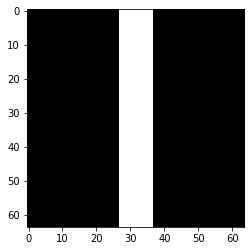

In [3]:
H = 64
image = np.zeros((H, H))
image[:, 32-5:32+5] = 1
plt.imshow(image, 'gray')

In [4]:
image = torch.tensor(image[None, None])
print(image.shape)

torch.Size([1, 1, 64, 64])


In [5]:
v1 = nn.Parameter(torch.randn(1, 2, H, H))
v2 = nn.Parameter(torch.randn(1, 2, H, H))

'''
nn module for integration
'''
class Dir(nn.Module):
    def __init__(self, v1, v2, img, ):
        super().__init__()
        self.v1 = v1
        self.v2 = v2
        self.img = img
    
    def forward(self, t, x):
        return self.v1, self.v2

In [8]:
model = Dir(v1, v2, image)

# Try to formulate the ODE equations

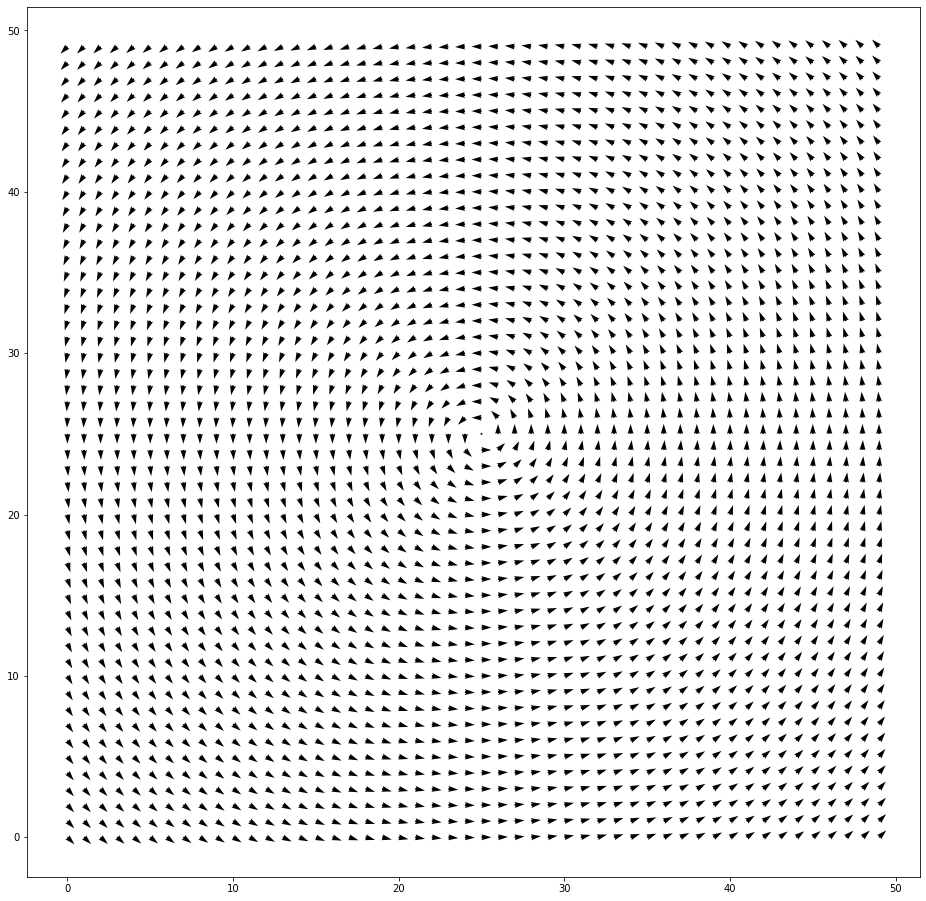

In [147]:
xx = (np.arange(100) - 50)/100
xx, yy = np.meshgrid(xx, xx)
xx, yy = -yy, xx
# yy = yy*0

# normalize
norm = np.sqrt(xx**2 + yy**2 + 1e-5)
xx = xx / norm
yy = yy / norm
plt.figure(figsize=(16, 16))
plt.quiver(xx[::2, ::2], yy[::2, ::2])

In [320]:
class Lambda(nn.Module):
    def __init__(self, v):
        super().__init__()
        self.a = torch.tensor(v)  # [2, H, W]
    
    def forward(self, t, xv):
        x = xv[:2]
        v = xv[2:]        
        a = -x - 0.1*v
#         print(a)
        
        dx = torch.cat([v, a])
        return dx

V = np.concatenate([xx[None], yy[None]], 0)
V = torch.FloatTensor(V)
print(V.shape)

torch.Size([2, 100, 100])


In [321]:
func = Lambda(V)

/pghbio/dbmi/batmanlab/rohit33/CIP/CIPPython-install/envs/vesselseg/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


In [322]:
xstart = [7, 0, 0, 1]
xstart = torch.FloatTensor(xstart)
x = odeint(func, xstart, torch.linspace(0, 50, 500), method='dopri5')

In [323]:
x.shape

torch.Size([500, 4])

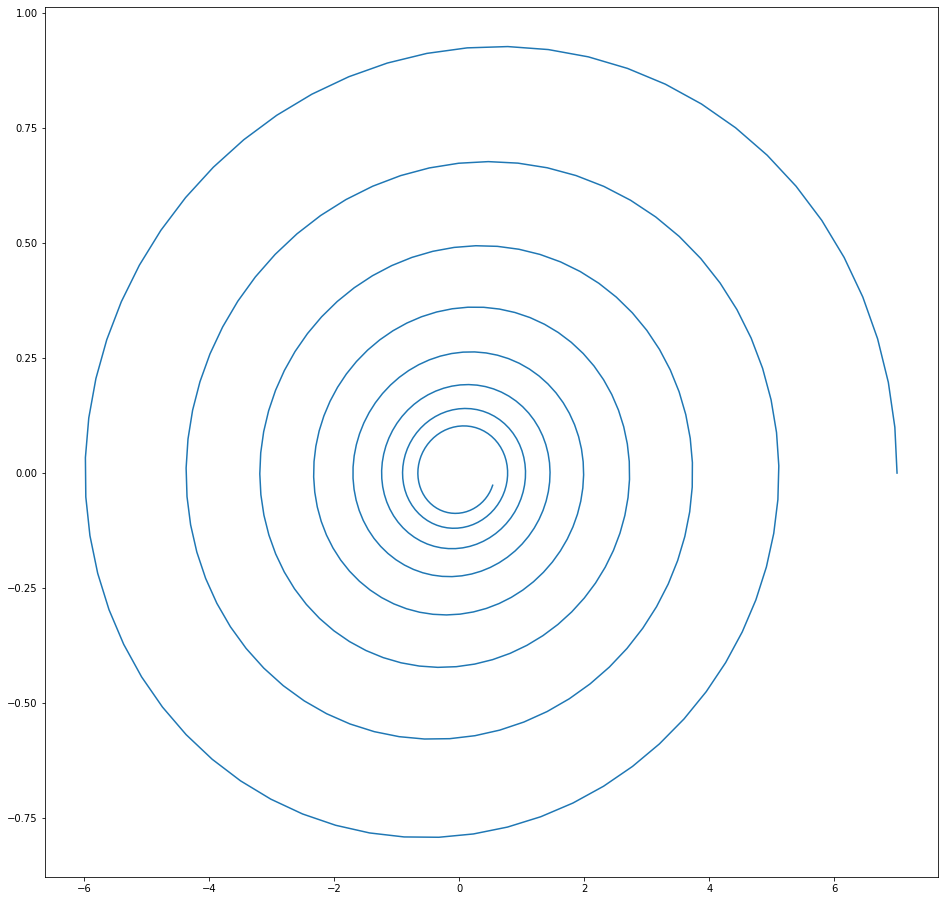

In [324]:
plt.figure(figsize=(16, 16))
# plt.quiver(xx[::1, ::1], yy[::1, ::1])
x1 = x[:, 0]
y1 = x[:, 1]
plt.plot(x1, y1)